# Data Wrangling with OpenStreetMap and MongoDB

OpenStreetMap is a community built free editable map of the world, inspired by the success of Wikipedia where crowdsourced data is open and free from proprietary restricted use. We see some examples of its use by Craigslist and Foursquare, as an open source alternative to Google Maps.

http://www.openstreetmap.org

Users can map things such as polylines of roads, draw polygons of buildings or areas of interest, or insert nodes for landmarks. These map elements can be further tagged with details such as street addresses or amenity type. Map data is stored in an XML format. More details about the OSM XML can be found here:

http://wiki.openstreetmap.org/wiki/OSM_XML

Some highlights of the OSM XML format relevent to this project are:
- OSM XML is list of instances of data primatives (nodes, ways, and relations) found within a given bounds
- nodes represent dimensionless points on the map
- ways contain node references to form either a polyline or polygon on the map
- nodes and ways both contain children tag elements that represent key value pairs of descriptive information about a given node or way

As with any user generated content, there is likely going to be dirty data. In this project I'll attempt to do some auditing, cleaning, and data summarizing tasks with Python and MongoDB.

## Chosen Map Area

For this project, I chose to ~50MB from the Cupertino, West San Jose Area. I grew up in Cupertino and lived through the tech sprawl of Apple and the Asian/Indian gentrification of the area. I figured that my familiarity with the area and intrinsic interest in my hometown makes it a good candidate for analysis.

In [1]:
from IPython.display import HTML
HTML('<iframe width="425" height="350" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" src="http://www.openstreetmap.org/export/embed.html?bbox=-122.1165%2C37.2571%2C-121.9060%2C37.3636&amp;layer=mapnik"></iframe><br/><small><a href="http://www.openstreetmap.org/#map=12/37.3105/-122.0135" target="_blank">View Larger Map</a></small>')

I used the Overpass API to download the OpenStreetMap XML for the corresponding bounding box:

http://overpass-api.de/api/map?bbox=-122.1165,37.2571,-121.9060,37.3636

In [2]:
import requests

url = 'http://overpass-api.de/api/map?bbox=-122.1165%2C37.2571%2C-121.9060%2C37.3636'
filename = 'cupertino_california.osm'

Python's Requests library is pretty awesome for downloading this dataset, but it unfortunately keeps all the data in memory by default. Since we're using a much larger dataset, we overcome this limitation with this modified procedure from this stackoverflow post:

http://stackoverflow.com/a/16696317

In [3]:
def download_file(url, local_filename):
    # stream = True allows downloading of large files; prevents loading entire file into memory
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
                
download_file(url, filename)

## Auditing the Data

With the OSM XML file downloaded, lets parse through it with ElementTree and count the number of unique element types. Iterative parsing is utilized since the XML is too large to process in memory.

In [4]:
import xml.etree.ElementTree as ET
import pprint

tags = {}

for event, elem in ET.iterparse(filename):
    if elem.tag in tags: tags[elem.tag] += 1
    else:                tags[elem.tag] = 1

pprint.pprint(tags)

{'bounds': 1,
 'member': 6644,
 'meta': 1,
 'nd': 255022,
 'node': 214642,
 'note': 1,
 'osm': 1,
 'relation': 313,
 'tag': 165782,
 'way': 28404}


Here I have built three regular expressions: `lower`, `lower_colon`, and `problemchars`.
- `lower`: matches strings containing lower case characters
- `lower_colon`: matches strings containing lower case characters and a single colon within the string
- `problemchars`: matches characters that cannot be used within keys in MongoDB
Here is a sample of OSM XML:
```
<node id="266587529" lat="37.3625767" lon="-122.0251570" version="4" timestamp="2015-03-30T03:17:30Z" changeset="29840833" uid="2793982" user="Dhruv Matani">
    <tag k="addr:city" v="Sunnyvale"/>
    <tag k="addr:housenumber" v="725"/>
    <tag k="addr:postcode" v="94086"/>
    <tag k="addr:state" v="California"/>
    <tag k="addr:street" v="South Fair Oaks Avenue"/>
    <tag k="amenity" v="restaurant"/>
    <tag k="cuisine" v="indian"/>
    <tag k="name" v="Arka"/>
    <tag k="opening_hours" v="10am - 2:30pm and 5:00pm - 10:00pm"/>
    <tag k="takeaway" v="yes"/>
</node>
```
Within the node element there are ten `tag` children. The key for half of these children begin with `addr:`. Later in this notebook I will use the `lower_colon` regex to help find these keys so I can build a single `address` document within a larger json document.

In [5]:
import re

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    if element.tag == "tag":
        for tag in element.iter('tag'):
            k = tag.get('k')
            if lower.search(k):
                keys['lower'] += 1
            elif lower_colon.search(k):
                keys['lower_colon'] += 1
            elif problemchars.search(k):
                keys['problemchars'] += 1
            else:
                keys['other'] += 1
        
    return keys

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

keys = process_map(filename)
pprint.pprint(keys)

{'lower': 78267, 'lower_colon': 83553, 'other': 3962, 'problemchars': 0}


Now lets redefine `process_map` to build a set of unique userid's found within the XML. I will then output the length of this set, representing the number of unique users making edits in the chosen map area.

In [6]:
def process_map(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        for e in element:
            if 'uid' in e.attrib:
                users.add(e.attrib['uid'])

    return users

users = process_map(filename)
len(users)

534

# Problems with the Data

**Street Names**

The majority of this project will be devoted to auditing and cleaning street names seen within the OSM XML. Street types used by users in the process of mapping are quite often abbreviated. I will attempt to find these abbreviations and replace them with their full text form. The plan of action is as follows:
- Build a regex to match the last token in a string (with an optional '.') as this is typically where you would find the street type in an address
- Build a list of expected street types that do not need to be cleaned
- Parse through the XML looking for tag elements with `k="addr:street"` attributes
- Perform a search using the regex on the value of the v attribute of these elements (the street name string)
- Build a dictionary with keys that are matches to the regex (street types) and a set of street names where the particular key was found as the value. This will allow us to determine what needs to be cleaned.
- Build a second dictionary that contains a map from an offending street type to a clean street type
- Build a second regex that will match these offending street types anywhere in a string
- Build a function that will return a clean string using the mapping dictionary and this second regex

The first step is to build a regex to match the last token in a string optionally ending with a period. I will also build a list of street types I expect to see in a clean street name.

In [7]:
from collections import defaultdict

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected_street_types = ["Avenue", "Boulevard", "Commons", "Court", "Drive", "Lane", "Parkway", 
                         "Place", "Road", "Square", "Street", "Trail"]

The `audit_street_type` function will take in the dictionary of street types we are building, a string to audit, a regex to match against that string, and the list of expected street types.

The function will search the string for the regex. If there is a match and the match is not in our list of expected street types, add the match as a key to the dictionary and add the string to the set.

In [8]:
def audit_street_type(street_types, street_name, regex, expected_street_types):
    m = regex.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected_street_types:
            street_types[street_type].add(street_name)

The function `is_street_name` determines if an element contains an attribute `k="addr:street"`. Lets use `is_street_name` as the `tag_filter` when I call the `audit` function to audit street names.

In [9]:
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

Now I will define an `audit` function to do the parsing and auditing of the street names.

I have defined this function so that it not only audits `tag` elements where `k="addr:street"`, but whichever `tag` elements match the `tag_filter` function. The audit function also takes in a regex and the list of expected matches.

In [10]:
def audit(osmfile, regex):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    
    # iteratively parse the mapping xml
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        # iterate 'tag' tags within 'node' and 'way' tags
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'], regex, expected_street_types)

    return street_types

Now lets pretty print the output of `audit`

In [11]:
street_types = audit(filename, street_type_re)

pprint.pprint(dict(street_types))

{'Alameda': set(['The Alameda']),
 'Ave': set(['Afton Ave',
             'Blake Ave',
             'Cabrillo Ave',
             'N Blaney Ave',
             'Saratoga Ave',
             'The Alameda Ave']),
 'Bascom': set(['S. Bascom']),
 'Bellomy': set(['Bellomy']),
 'Blvd': set(['De Anza Blvd', 'Stevens Creek Blvd']),
 'Circle': set(['Bobolink Circle',
                'Calabazas Creek Circle',
                'Continental Circle',
                'Winchester Circle']),
 'Dr': set(['Linwood Dr']),
 'East': set(['Vanderbilt Court East']),
 'Escuela': set(['Camina Escuela']),
 'Franklin': set(['Franklin']),
 'Ln': set(['Weyburn Ln']),
 'Loop': set(['Infinite Loop']),
 'Presada': set(['Paseo Presada']),
 'Rd': set(['Bollinger Rd', 'Homestead Rd', 'Saratoga Los Gatos Rd']),
 'Real': set(['E El Camino Real', 'East El Camino Real', 'El Camino Real']),
 'Row': set(['Santana Row']),
 'St': set(['Monroe St']),
 'Terrace': set(['Avon Terrace',
                 'Avoset Terrace',
                

Now I have a list of some abbreviated street types (as well as locations without street types). This is by no means a comprehensive list of all of the abbreviated street types used within the XML as all of these matches occur only as the last token at the end of a street name, but it is a very good first swipe at the problem.

To replace these abbreviated street types, I will define an update function that takes a string to update, a mapping dictionary, and a regex to search.

In [12]:
def update_name(name, mapping, regex):
    m = regex.search(name)
    if m:
        street_type = m.group()
        if street_type in mapping:
            name = re.sub(regex, mapping[street_type], name)

    return name

Using the results of `audit`, I will build a dictionary to map abbreviations to their full, clean representations.

In [13]:
street_type_mapping = {'Ave'  : 'Avenue',
                       'Blvd' : 'Boulevard',
                       'Dr'   : 'Drive',
                       'Ln'   : 'Lane',
                       'Pkwy' : 'Parkway',
                       'Rd'   : 'Road',
                       'St'   : 'Street'}

I now want to replace the keys of the map anywhere in the string. I'll build a new regex to do so.

In [14]:
# The pipe will cause the regex to search for any of the keys, lazily matching the first it finds
street_type_re  = re.compile(r'\b\S+\.?$', re.IGNORECASE)

To see how this works, I will traverse the `street_types` dictionary from above

In [15]:
for street_type, ways in street_types.iteritems():
    for name in ways:
        better_name = update_name(name, street_type_mapping, street_type_re)
        print name, "=>", better_name

El Camino Real => El Camino Real
E El Camino Real => E El Camino Real
East El Camino Real => East El Camino Real
S. Bascom => S. Bascom
Bellomy => Bellomy
Winchester => Winchester
Weyburn Ln => Weyburn Lane
Linwood Dr => Linwood Drive
Franklin => Franklin
Monroe St => Monroe Street
Bollinger Rd => Bollinger Road
Saratoga Los Gatos Rd => Saratoga Los Gatos Road
Homestead Rd => Homestead Road
Vanderbilt Court East => Vanderbilt Court East
Riorden Terrace => Riorden Terrace
Yellowstone Terrace => Yellowstone Terrace
Springfield Terrace => Springfield Terrace
Oak Point Terrace => Oak Point Terrace
Windsor Terrace => Windsor Terrace
Lessing Terrace => Lessing Terrace
Avon Terrace => Avon Terrace
Hobart Terrace => Hobart Terrace
Wright Terrace => Wright Terrace
Hogarth Terrace => Hogarth Terrace
Manet Terrace => Manet Terrace
Pyracantha Terrace => Pyracantha Terrace
Pistachio Terrace => Pistachio Terrace
Wilmington Terrace => Wilmington Terrace
Avoset Terrace => Avoset Terrace
Lautrec Terrac

Looks like the abbreviated street types updated as expected.

Upon closer inspection, I see another problem: cardinal directions. North, South, East, and West appear to be universally abbreviated. Lets apply similar techniques to replace these abbreviated cardinal directions.

First, I will create a new regex matching the set of characters NSEW at the beginning of a string, followed by an optional period

In [16]:
street_type_pre = re.compile(r'^[NSEW]\b\.?', re.IGNORECASE)

To audit, I can use the same function with this new regex

In [17]:
cardinal_directions = audit(filename, street_type_pre)

pprint.pprint(dict(cardinal_directions))

{'E': set(['E El Camino Real']),
 'N': set(['N Blaney Ave']),
 'S.': set(['S. Bascom'])}


Looks like we found E, N, S, W, and W. at beginning of the street names. Informative, but I can just create an exhaustive mapping for this issue

In [18]:
cardinal_mapping = {'E'  : 'East',
                    'E.' : 'East',
                    'N'  : 'North',
                    'N.' : 'North',
                    'S'  : 'South',
                    'S.' : 'South',
                    'W'  : 'West',
                    'W.' : 'West'}

Finally, I will traverse the `cardinal_directions` dictionary and apply the updates for both street type and cardinal direction

In [19]:
for cardinal_direction, ways in cardinal_directions.iteritems():
    if cardinal_direction in cardinal_mapping:
        for name in ways:
            better_name = update_name(name, street_type_mapping, street_type_re)
            best_name   = update_name(better_name, cardinal_mapping, street_type_pre)
            print name, "=>", better_name, "=>", best_name

E El Camino Real => E El Camino Real => East El Camino Real
S. Bascom => S. Bascom => South Bascom
N Blaney Ave => N Blaney Avenue => North Blaney Avenue


## Preparing for MongoDB

To load the XML data into MongoDB, I will have to transform the data into json documents structured like this:
```
{
    "id": "2406124091",
    "type: "node",
    "visible":"true",
    "created": {
                  "version":"2",
                  "changeset":"17206049",
                  "timestamp":"2013-08-03T16:43:42Z",
                  "user":"linuxUser16",
                  "uid":"1219059"
               },
    "pos": [41.9757030, -87.6921867],
    "address": {
                  "housenumber": "5157",
                  "postcode": "60625",
                  "street": "North Lincoln Ave"
               },
    "amenity": "restaurant",
    "cuisine": "mexican",
    "name": "La Cabana De Don Luis",
    "phone": "1 (773)-271-5176"
}
```
The transform will follow these rules:
- Process only 2 types of top level tags: node and way
- All attributes of node and way should be turned into regular key/value pairs, except:
  - The following attributes should be added under a key `created: version, changeset, timestamp, user, uid`
  - Attributes for latitude and longitude should be added to a pos array, for use in geospacial indexing. Make sure the values inside pos array are floats and not strings.
- If second level `tag` "k" value contains problematic characters, it should be ignored
- If second level `tag` "k" value starts with "addr:", it should be added to a dictionary address
- If second level `tag` "k" value does not start with "addr:", but contains ":", you can process it same as any other tag.
- If there is a second ":" that separates the type/direction of a street, the tag should be ignored, for example:
```
<tag k="addr:housenumber" v="5158"/>
<tag k="addr:street" v="North Lincoln Avenue"/>
<tag k="addr:street:name" v="Lincoln"/>
<tag k="addr:street:prefix" v="North"/>
<tag k="addr:street:type" v="Avenue"/>
<tag k="amenity" v="pharmacy"/>
```
should be turned into:
```
{
    "address": {
                   "housenumber": 5158,
                   "street": "North Lincoln Avenue"
               },
    "amenity": "pharmacy"
}
```
For "way" specifically:
```
<nd ref="305896090"/>
<nd ref="1719825889"/>
```
should be turned into:
```
{
    "node_refs": ["305896090", "1719825889"]
}
```
To do this transformation, lets define a function `shape_element` that processes an element. Within this function I will use the update function with the regexes and mapping dictionaries defined above to clean street addresses. Additionally, I will store timestamp as a Python `datetime` rather than as a string. The format of the timestamp can be found here:

http://overpass-api.de/output_formats.html

In [20]:
from datetime import datetime

CREATED = ["version", "changeset", "timestamp", "user", "uid"]

def shape_element(element):
    node = {}    
    if element.tag == "node" or element.tag == "way" :
        node['type'] = element.tag
        
        # Parse attributes
        for attrib in element.attrib:

            # Data creation details
            if attrib in CREATED:
                if 'created' not in node:
                    node['created'] = {}
                if attrib == 'timestamp':
                    node['created'][attrib] = datetime.strptime(element.attrib[attrib], '%Y-%m-%dT%H:%M:%SZ')
                else:
                    node['created'][attrib] = element.get(attrib)

            # Parse location
            if attrib in ['lat', 'lon']:
                lat = float(element.attrib.get('lat'))
                lon = float(element.attrib.get('lon'))
                node['pos'] = [lat, lon]

            # Parse the rest of attributes
            else:
                node[attrib] = element.attrib.get(attrib)
            
        # Process tags
        for tag in element.iter('tag'):
            key   = tag.attrib['k']
            value = tag.attrib['v']
            if not problemchars.search(key):

                # Tags with single colon and beginning with addr
                if lower_colon.search(key) and key.find('addr') == 0:
                    if 'address' not in node:
                        node['address'] = {}
                    sub_attr = key.split(':')[1]
                    if is_street_name(tag):
                        # Do some cleaning
                        better_name = update_name(name, street_type_mapping, street_type_re)
                        best_name   = update_name(better_name, cardinal_mapping, street_type_pre)
                        node['address'][sub_attr] = best_name
                    else:    
                        node['address'][sub_attr] = value

                # All other tags that don't begin with "addr"
                elif not key.find('addr') == 0:
                    if key not in node:
                        node[key] = value
                else:
                    node["tag:" + key] = value
        
        # Process nodes
        for nd in element.iter('nd'):
            if 'node_refs' not in node:
                node['node_refs'] = []
            node['node_refs'].append(nd.attrib['ref'])

        return node
    else:
        return None

Now parse the XML, shape the elements, and write to a json file.

We're using BSON for compatibility with the date aggregation operators. There is also a Timestamp type in MongoDB, but use of this type is explicitly discouraged by the [documentation](http://docs.mongodb.org/manual/core/document/#timestamps).

In [21]:
import json
from bson import json_util

def process_map(file_in, pretty = False):
    file_out = "{0}.json".format(file_in)    
    with open(file_out, "wb") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                if pretty:
                    fo.write(json.dumps(el, indent=2, default=json_util.default)+"\n")
                else:
                    fo.write(json.dumps(el, default=json_util.default) + "\n")

process_map(filename)

## Overview of the Data

Lets look at the size of the files we worked with and generated.

In [22]:
import os
print 'The downloaded file is {} MB'.format(os.path.getsize(filename)/1.0e6) # convert from bytes to megabytes

The downloaded file is 50.66996 MB


In [23]:
print 'The json file is {} MB'.format(os.path.getsize(filename + ".json")/1.0e6) # convert from bytes to megabytes

The json file is 83.383804 MB


**Plenty of Street Addresses**

Besides dirty data within the `addr:street` field, we're working with a sizeable amount of data on street addresses. Here I will count the total number of nodes and ways that contain a tag child with `k="addr:street"`

In [24]:
osm_file = open(filename, "r")
address_count = 0

for event, elem in ET.iterparse(osm_file, events=("start",)):
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"): 
            if is_street_name(tag):
                address_count += 1

address_count

8958

There are plenty of locations on the map that has their street addresses tagged. It looks like OpenStreetMap's community has collected a good amount of data for this area.

## Working with MongoDB

The first task is to execute mongod to run MongoDB. There are plenty of guides to do this. On OS X, if you have `mongodb` installed via homebrew, homebrew actually has a handy `brew services` command.

To start mongodb:

    brew services start mongodb

To stop mongodb if it's already running:

    brew services stop mongodb

Alternatively, if you have MongoDB installed and configured already we can run a subprocess for the duration of the python session:

In [25]:
import signal
import subprocess

# The os.setsid() is passed in the argument preexec_fn so
# it's run after the fork() and before  exec() to run the shell.
pro = subprocess.Popen('mongod', preexec_fn = os.setsid)

Next, connect to the database with `pymongo`

In [26]:
from pymongo import MongoClient

db_name = 'openstreetmap'

# Connect to Mongo DB
client = MongoClient('localhost:27017')
# Database 'openstreetmap' will be created if it does not exist.
db = client[db_name]

Then just import the dataset with `mongoimport`.

In [27]:
# Build mongoimport command
collection = filename[:filename.find('.')]
working_directory = '/Users/James/Dropbox/Projects/da/data-wrangling-with-openstreetmap-and-mongodb/'
json_file = filename + '.json'

mongoimport_cmd = 'mongoimport -h 127.0.0.1:27017 ' + \
                  '--db ' + db_name + \
                  ' --collection ' + collection + \
                  ' --file ' + working_directory + json_file

# Before importing, drop collection if it exists (i.e. a re-run)
if collection in db.collection_names():
    print 'Dropping collection: ' + collection
    db[collection].drop()
    
# Execute the command
print 'Executing: ' + mongoimport_cmd
subprocess.call(mongoimport_cmd.split())

Dropping collection: cupertino_california
Executing: mongoimport -h 127.0.0.1:27017 --db openstreetmap --collection cupertino_california --file /Users/James/Dropbox/Projects/da/data-wrangling-with-openstreetmap-and-mongodb/cupertino_california.osm.json


0

## Investigating the Data

After importing, get the collection from the database.

In [28]:
cupertino_california = db[collection]

Here's where the fun stuff starts. Now that we have a audited and cleaned up collection, we can query for a bunch of interesting statistics.

**Number of Documents**

In [29]:
cupertino_california.find().count()

243046

**Number of Unique Users**

In [30]:
len(cupertino_california.distinct('created.user'))

528

**Number of Nodes and Ways**

In [31]:
cupertino_california.aggregate({'$group': {'_id': '$type', \
                                           'count': {'$sum' : 1}}})['result']

[{u'_id': u'way', u'count': 28404}, {u'_id': u'node', u'count': 214642}]

**Top Three Contributors**

In [32]:
top_users = cupertino_california.aggregate([{'$group': {'_id': '$created.user', \
                                                        'count': {'$sum' : 1}}}, \
                                            {'$sort': {'count' : -1}}, \
                                            {'$limit': 3}])['result']

pprint.pprint(top_users)
print

for user in top_users:
    pprint.pprint(cupertino_california.find({'created.user': user['_id']})[0])

[{u'_id': u'n76', u'count': 66090},
 {u'_id': u'mk408', u'count': 37175},
 {u'_id': u'Bike Mapper', u'count': 27545}]

{u'_id': ObjectId('55e69dc45c014321a5c76759'),
 u'changeset': u'16866449',
 u'created': {u'changeset': u'16866449',
              u'timestamp': datetime.datetime(2013, 7, 7, 21, 29, 38),
              u'uid': u'318696',
              u'user': u'n76',
              u'version': u'21'},
 u'highway': u'traffic_signals',
 u'id': u'26027690',
 u'pos': [37.3531613, -122.0140663],
 u'timestamp': u'2013-07-07T21:29:38Z',
 u'type': u'node',
 u'uid': u'318696',
 u'user': u'n76',
 u'version': u'21'}
{u'_id': ObjectId('55e69dc45c014321a5c76765'),
 u'changeset': u'3923975',
 u'created': {u'changeset': u'3923975',
              u'timestamp': datetime.datetime(2010, 2, 20, 14, 28, 36),
              u'uid': u'201724',
              u'user': u'mk408',
              u'version': u'2'},
 u'id': u'26117855',
 u'pos': [37.3584066, -122.016459],
 u'timestamp': u'2010-02-20T14:28:36Z',
 u'typ

**Three Most Referenced Nodes**

In [33]:
top_nodes = cupertino_california.aggregate([{'$unwind': '$node_refs'}, \
                                            {'$group': {'_id': '$node_refs', \
                                                        'count': {'$sum': 1}}}, \
                                            {'$sort': {'count': -1}}, \
                                            {'$limit': 3}])['result']

pprint.pprint(top_nodes)
print

for node in top_nodes:
    pprint.pprint(cupertino_california.find({'id': node['_id']})[0])

[{u'_id': u'282814553', u'count': 9},
 {u'_id': u'3567695709', u'count': 7},
 {u'_id': u'3678198975', u'count': 7}]

{u'_id': ObjectId('55e69dc45c014321a5c7b228'),
 u'changeset': u'32109704',
 u'created': {u'changeset': u'32109704',
              u'timestamp': datetime.datetime(2015, 6, 21, 5, 7, 49),
              u'uid': u'33757',
              u'user': u'Minh Nguyen',
              u'version': u'19'},
 u'highway': u'traffic_signals',
 u'id': u'282814553',
 u'pos': [37.3520588, -121.93721],
 u'timestamp': u'2015-06-21T05:07:49Z',
 u'type': u'node',
 u'uid': u'33757',
 u'user': u'Minh Nguyen',
 u'version': u'19'}
{u'_id': ObjectId('55e69dca5c014321a5ca7eed'),
 u'changeset': u'31682562',
 u'created': {u'changeset': u'31682562',
              u'timestamp': datetime.datetime(2015, 6, 3, 4, 56, 24),
              u'uid': u'33757',
              u'user': u'Minh Nguyen',
              u'version': u'1'},
 u'id': u'3567695709',
 u'pos': [37.3354655, -121.9078015],
 u'timestamp': u'2015-06-03T

**Number of Documents with Street Addresses**

In [34]:
cupertino_california.find({'address.street': {'$exists': 1}}).count()

9095

**List of Zip Codes**

In [35]:
cupertino_california.aggregate([{'$match': {'address.postcode': {'$exists': 1}}}, \
                                {'$group': {'_id': '$address.postcode', \
                                            'count': {'$sum': 1}}}, \
                                {'$sort': {'count': -1}}])['result']

[{u'_id': u'94087', u'count': 226},
 {u'_id': u'95070', u'count': 225},
 {u'_id': u'95051', u'count': 127},
 {u'_id': u'95014', u'count': 106},
 {u'_id': u'95129', u'count': 86},
 {u'_id': u'95126', u'count': 45},
 {u'_id': u'95008', u'count': 41},
 {u'_id': u'95050', u'count': 28},
 {u'_id': u'95125', u'count': 13},
 {u'_id': u'94086', u'count': 12},
 {u'_id': u'95117', u'count': 9},
 {u'_id': u'95128', u'count': 8},
 {u'_id': u'94024', u'count': 5},
 {u'_id': u'95124', u'count': 4},
 {u'_id': u'94040', u'count': 3},
 {u'_id': u'95032', u'count': 3},
 {u'_id': u'94087-2248', u'count': 1},
 {u'_id': u'94087\u200e', u'count': 1},
 {u'_id': u'94088-3707', u'count': 1},
 {u'_id': u'95110', u'count': 1},
 {u'_id': u'95052', u'count': 1},
 {u'_id': u'CA 95014', u'count': 1},
 {u'_id': u'95914', u'count': 1},
 {u'_id': u'94022', u'count': 1},
 {u'_id': u'CA 94086', u'count': 1}]

It looks like have some invalid zip codes, with the state name or unicode characters included.

The zip codes with 4 digit postal codes included are still valid though, and we might consider removing these postal codes during the cleaning process.

**Cities with Most Records**

In [36]:
cupertino_california.aggregate([{'$match': {'address.city': {'$exists': 1}}}, \
                                {'$group': {'_id': '$address.city', \
                                            'count': {'$sum': 1}}}, \
                                {'$sort': {'count': -1}}])['result']


[{u'_id': u'Sunnyvale', u'count': 2476},
 {u'_id': u'Saratoga', u'count': 221},
 {u'_id': u'Santa Clara', u'count': 142},
 {u'_id': u'San Jose', u'count': 99},
 {u'_id': u'Cupertino', u'count': 59},
 {u'_id': u'Campbell', u'count': 37},
 {u'_id': u'San Jos\xe9', u'count': 9},
 {u'_id': u'Los Altos', u'count': 7},
 {u'_id': u'Campbelll', u'count': 3},
 {u'_id': u'Mountain View', u'count': 3},
 {u'_id': u'cupertino', u'count': 2},
 {u'_id': u'Santa clara', u'count': 1},
 {u'_id': u'santa clara', u'count': 1},
 {u'_id': u'campbell', u'count': 1},
 {u'_id': u'san jose', u'count': 1},
 {u'_id': u'Los Gatos', u'count': 1},
 {u'_id': u'South Mary Avenue', u'count': 1},
 {u'_id': u'sunnyvale', u'count': 1}]

Likewise, some cities capitalization and the accented-e gives way to more auditing and cleaning.

It's interesting to note how well Sunnyvale and Santa Clara have been documented, relative to the other cities despite having the area covering mostly Cupertino, Saratoga, West San Jose.

**Top 10 Amenities**

In [37]:
cupertino_california.aggregate([{'$match': {'amenity': {'$exists': 1}}}, \
                                {'$group': {'_id': '$amenity', \
                                            'count': {'$sum': 1}}}, \
                                {'$sort': {'count': -1}}, \
                                {'$limit': 10}])['result']

[{u'_id': u'parking', u'count': 437},
 {u'_id': u'restaurant', u'count': 279},
 {u'_id': u'school', u'count': 243},
 {u'_id': u'place_of_worship', u'count': 153},
 {u'_id': u'fast_food', u'count': 147},
 {u'_id': u'cafe', u'count': 85},
 {u'_id': u'fuel', u'count': 79},
 {u'_id': u'bicycle_parking', u'count': 72},
 {u'_id': u'bank', u'count': 66},
 {u'_id': u'bench', u'count': 60}]

** Top 10 Banks**

It's a pain when there isn't a local branch of your bank closeby. Lets what banks have the most locations in this area to avoid this.

In [38]:
cupertino_california.aggregate([{'$match': {'amenity': 'bank'}}, \
                                {'$group': {'_id': '$name', \
                                            'count': {'$sum': 1}}}, \
                                {'$sort': {'count': -1}}, \
                                {'$limit': 10}])['result']

[{u'_id': u'Bank of America', u'count': 10},
 {u'_id': u'Chase', u'count': 8},
 {u'_id': None, u'count': 7},
 {u'_id': u'US Bank', u'count': 5},
 {u'_id': u'Citibank', u'count': 5},
 {u'_id': u'Wells Fargo', u'count': 5},
 {u'_id': u'First Tech Federal Credit Union', u'count': 2},
 {u'_id': u'Union Bank', u'count': 2},
 {u'_id': u'Bank of the West', u'count': 2},
 {u'_id': u'Chase Bank', u'count': 2}]

## Other Ideas About the Dataset

From exploring the OpenStreetMap dataset, I found the data structure to be flexible enough to include a vast multitude of user generated quantitative and qualitative data beyond that of simply defining a virtual map. There's plenty of potential to extend OpenStreetMap to include user reviews of establishments, subjective areas of what classifies a good vs bad neighborhood, housing price data, school reviews, walkability/bikeability, quality of mass transit, and a bunch of other metrics that could form a solid foundation for robust recommender systems. These recommender systems could aid users in deciding where to live or what cool food joints to check out.

The data is far too incomplete to be able to implement such recommender systems as it stands now, but the OpenStreetMap project could really benefit from visualizing data on content generation within their maps. For example, a heat map layer could be overlayed on the map showing how frequently or how recently certain regions of the map have been updated. These map layers could help guide users towards areas of the map that need attention in order to help more fully complete the data set.

Next I will cover a couple of queries that are aligned with these ideas about the velocity and volume of content generation

**Amount of Nodes Elements Created by Day of Week**

I will use the `$dayOfWeek` operator to extract the day of week from the `created.timestamp` field, where 1 is Sunday and 7 is Saturday:

http://docs.mongodb.org/manual/reference/operator/aggregation/dayOfWeek/

In [39]:
cupertino_california.aggregate([{'$project': {'dayOfWeek': {'$dayOfWeek': '$created.timestamp'}}}, \
                                {'$group': {'_id': '$dayOfWeek', \
                                            'count': {'$sum': 1}}}, \
                                {'$sort': {'_id': 1}}])['result']

[{u'_id': 1, u'count': 44247},
 {u'_id': 2, u'count': 39205},
 {u'_id': 3, u'count': 39398},
 {u'_id': 4, u'count': 35923},
 {u'_id': 5, u'count': 33127},
 {u'_id': 6, u'count': 21174},
 {u'_id': 7, u'count': 29972}]

It seems like users were more active on in the beginning of the week.

**Age of Elements**

Lets see how old elements were created in the XML using the `created.timestamp` field and visualize this data by pushing the calculated values into a list.

In [40]:
ages = cupertino_california.aggregate([ \
               {'$project': {'ageInMilliseconds': {'$subtract': [datetime.now(), '$created.timestamp']}}}, \
               {'$project': {'_id': 0, \
                             'ageInDays': {'$divide': ['$ageInMilliseconds', 1000*60*60*24]}}}, \
               {'$group'  : {'_id': 1, \
                             'ageInDays': {'$push': '$ageInDays'}}}, \
               {'$project': {'_id': 0, \
                             'ageInDays': 1}}])['result'][0]

Now I have a dictionary with an `ageInDays` key and a list of floats as the value. Next, I will create a pandas dataframe from this dictionary

In [41]:
from pandas import DataFrame

age_df = DataFrame.from_dict(ages)
# age_df.index.name = 'element'
print age_df.head()

     ageInDays
0  1709.554143
1  1709.552893
2  1709.675798
3  1709.676018
4  1709.676331


Lets plot a histogram of this series with our best friend `ggplot`. The binwidth is set to 30 (about a month)

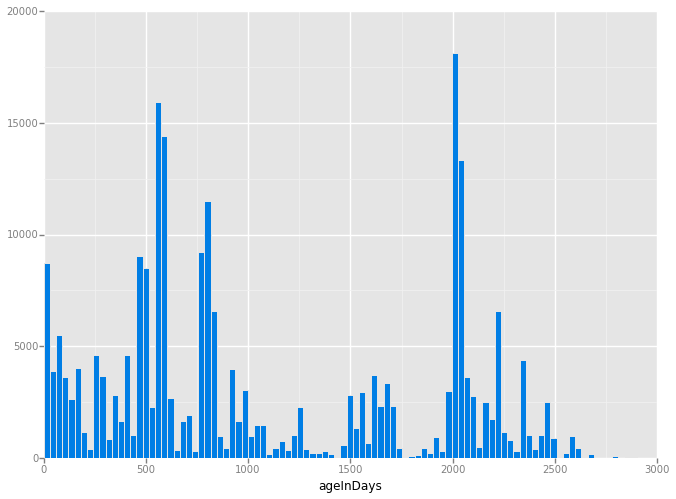

<ggplot: (322176817)>


In [42]:
%matplotlib inline
from ggplot import *
import warnings

# ggplot usage of pandas throws a future warning
warnings.filterwarnings('ignore')

print ggplot(aes(x='ageInDays'), data=age_df) + \
             geom_histogram(binwidth=30, fill='#007ee5')

Note the rise and fall of large spikes of activity occurring about every 400 days. I hypothesize that these are due to single users making many edits in this concentrated map area in a short period of time.